- Logistic Regression Intuition
- Multiclass Regression (One vs. All)
- Cross-Validation for Logistic vs. SVM vs. KNN
- F1, AUROC 


In [ ]:
!git clone https://github.com/BIOL359A-FoundationsOfQBio-Spr22/week6_logisticregression
!mkdir ./data
!cp week6_logisticregression/data/* ./data
!cp week6_logisticregression/clean_data.py ./

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk
import matplotlib.pyplot as plt
import pylab as pl
import ipywidgets as widgets

from sklearn import linear_model, neighbors, svm
from sklearn.datasets import make_classification
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score

%matplotlib inline

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

TITLE_FONT = 20
LABEL_FONT = 16
TICK_FONT = 16
FIG_SIZE = (10,10)
COLORS= ["#008080","#CA562C"]

sns.set(font_scale=1, rc={'figure.figsize':FIG_SIZE}) 
sns.set_style("white",  {'axes.linewidth': 2, 'axes.edgecolor':'black'})
plt.rc("axes.spines", top=False, right=False)


In [2]:
# define sigmoid function
def sigmoid(t):
    return 1/(1 + np.exp(-t))


In [3]:
@widgets.interact(beta_0 = (-2,2), beta_1 = (0.5,5))
def plot_logistic(beta_0=0, beta_1=2):
    sns.set_style("whitegrid")
    x = np.linspace(-10, 10)
    plt.plot(x, sigmoid(x), label = r"$\beta_0 = 0, \beta_1=1$")
    plt.plot(x, sigmoid(beta_0+beta_1*x), label = r"$\beta_0 = {}, \beta_1={}$".format(beta_0, beta_1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=LABEL_FONT)
    plt.title(r"$t = \beta_0 + \beta_1 x$", fontsize=TITLE_FONT)
    plt.text(-9, 1, r"$\sigma(x) = \frac{1}{1+e^{-t}}$", size=16, 
             ha="left", va="top",
             fontsize=LABEL_FONT,
             bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
             )
    plt.xlabel("x")
    plt.ylabel("y    ", rotation=0)
    

interactive(children=(IntSlider(value=0, description='beta_0', max=2, min=-2), FloatSlider(value=2.0, descript…

In [4]:
X, Y = make_classification(n_samples=201, n_features=2, n_redundant=0, class_sep=.9, random_state=111)

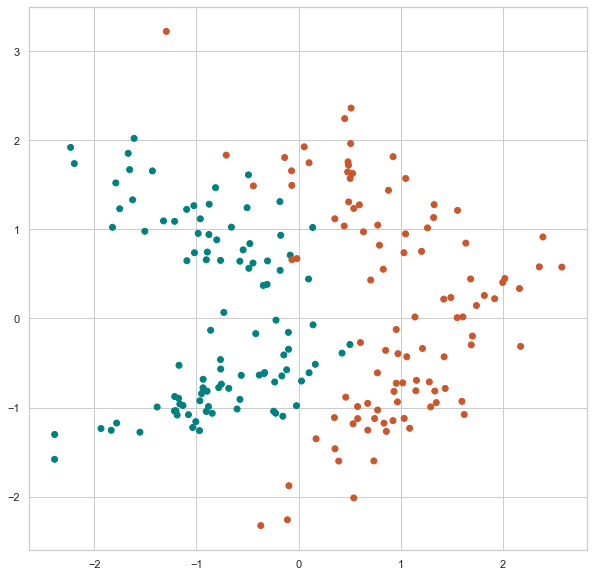

In [5]:
def plot_classification(X,Y):
    colors = [COLORS[y] for y in Y]
    pl.scatter(X[:,0], X[:,1], marker='o',c=colors)

plot_classification(X,Y)


In [6]:
# Create color maps
cmap_light = sns.diverging_palette(220, 20, as_cmap=True)

def visualize_classification_model(model, X,Y, step_size = .02, title="", cont=False):
    model.fit(X, Y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
    np.arange(y_min, y_max, step_size))
    
    if not cont:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    else: 
        temp_Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = temp_Z[:,1]
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=.3)
    colors = [COLORS[y] for y in Y]
    pl.scatter(X[:,0], X[:,1], marker='o',c=colors, edgecolor="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title, fontsize=TITLE_FONT)
    plt.show()

In [7]:
sns.set_style("white",  {'axes.linewidth': 2, 'axes.edgecolor':'black'})
def plot_logisticRegressionClassifier(X, Y):
    model = linear_model.LogisticRegression(penalty='none')
    title_string = f"Logistic Regression (no regularization)"
    visualize_classification_model(model, X, Y, title=title_string, cont=True)

def plot_svmClassifier(kernel, C, X, Y):
    model = svm.SVC(kernel=kernel)
    title_string = f"Support Vector Machine Classifier (kernel = {kernel}, C = {C})"
    visualize_classification_model(model, X, Y, title=title_string, cont=False)
    
def plot_nearestNeighborsClassifier(n_neighbors, X, Y):
    model = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
    title_string = f"Nearest Neighbors (K = {n_neighbors})"
    visualize_classification_model(model, X, Y, title=title_string)

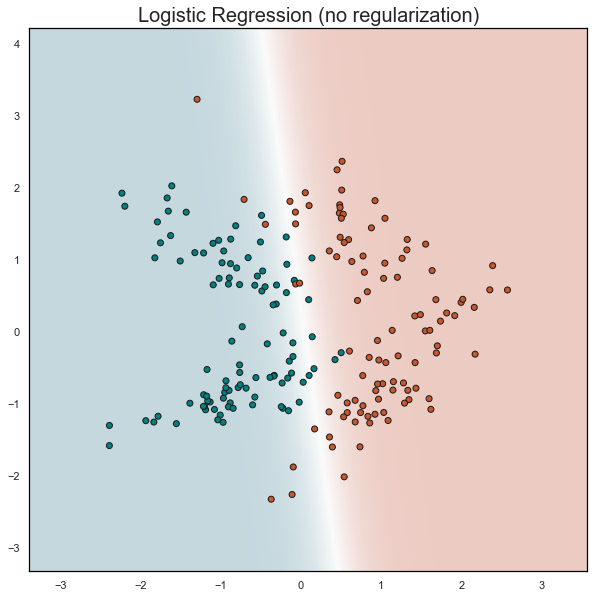

In [8]:
plot_logisticRegressionClassifier(X,Y)

In [9]:
@widgets.interact_manual(kernel=["linear", "poly", "rbf", "sigmoid"], C=(0,2))
def SVM_wrapper(kernel="linear", C=1):
    plot_svmClassifier(kernel, C, X, Y)

interactive(children=(Dropdown(description='kernel', options=('linear', 'poly', 'rbf', 'sigmoid'), value='line…

In [10]:
@widgets.interact_manual(K=(1, X.shape[0]))
def KNN_wrapper(K=5):
    plot_nearestNeighborsClassifier(K, X, Y)

interactive(children=(IntSlider(value=5, description='K', max=201, min=1), Button(description='Run Interact', …

In [38]:
def confusion_matrix(model, X,Y, title=""):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
    model.fit(X_train, y_train)
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues)
    try:
        score = f1_score(y_test, model.predict(X_test))
    except ValueError:
        y_test_binary = [1 if y == "M" else 0 for y in y_test]
        y_pred_binary = [1 if y == "M" else 0 for y in model.predict(X_test)]
        score = f1_score(y_test_binary, y_pred_binary)
    disp.ax_.set_title(title + r"  $F_1$ score = {0:.2f}".format(score))

In [39]:
def confusion_logisticRegressionClassifier(X, Y, plot=True):
    model = linear_model.LogisticRegression(penalty='none')
    title_string = f"Logistic Regression (no regularization)"
    if plot: visualize_classification_model(model, X, Y, title=title_string, cont=True)
    confusion_matrix(model, X, Y, title=title_string)

def confusion_svmClassifier(kernel, C, X, Y, plot=True):
    model = svm.SVC(kernel=kernel)
    title_string = f"Support Vector Machine Classifier (kernel = {kernel}, C = {C})"
    if plot: visualize_classification_model(model, X, Y, title=title_string, cont=False)
    confusion_matrix(model, X, Y, title=title_string)
    
def confusion_nearestNeighborsClassifier(n_neighbors, X, Y, plot=True):
    model = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
    title_string = f"Nearest Neighbors (K = {n_neighbors})"
    if plot: visualize_classification_model(model, X, Y, title=title_string, cont=False)
    confusion_matrix(model, X, Y, title=title_string)

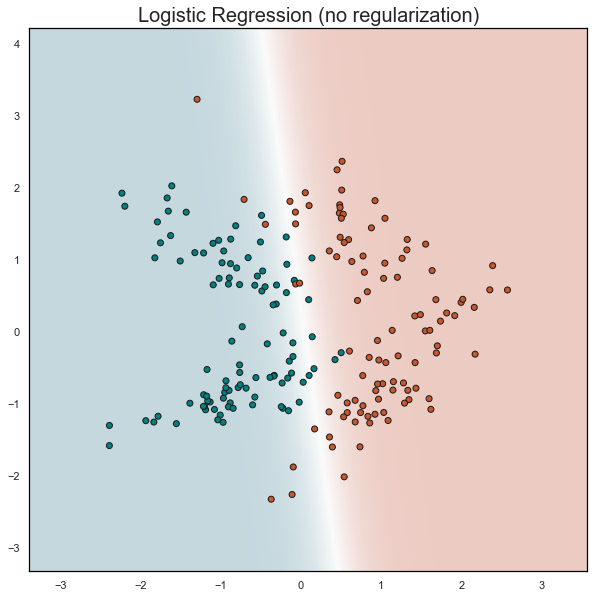

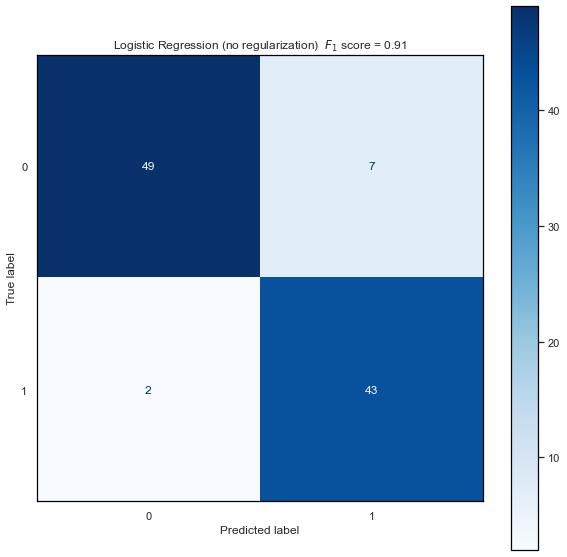

In [40]:
confusion_logisticRegressionClassifier(X,Y)

In [41]:
@widgets.interact_manual(kernel=["linear", "poly", "rbf", "sigmoid"], C=(0,2))
def SVM_wrapper(kernel="linear", C=1):
    confusion_svmClassifier(kernel, C, X, Y)

interactive(children=(Dropdown(description='kernel', options=('linear', 'poly', 'rbf', 'sigmoid'), value='line…

In [42]:
@widgets.interact_manual(K=(1, X.shape[0]))
def KNN_wrapper(K=5):
    confusion_nearestNeighborsClassifier(K, X, Y)

interactive(children=(IntSlider(value=5, description='K', max=201, min=1), Button(description='Run Interact', …

## Reciever Operator Curve

Or why is it important that logistic regression outputs a probability rather than a class? 

In [43]:
def logistic_roc_curve(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)
    clf = linear_model.LogisticRegression(penalty='l2', C=0.1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="auc= {0:.2f}".format(auc))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot([0,1], [0,1], "k--", label = "Random Model")
    plt.plot([0,0,1], [0,1,1], "k:", label = "Ideal Model")
    plt.legend(loc=4)
    plt.show()


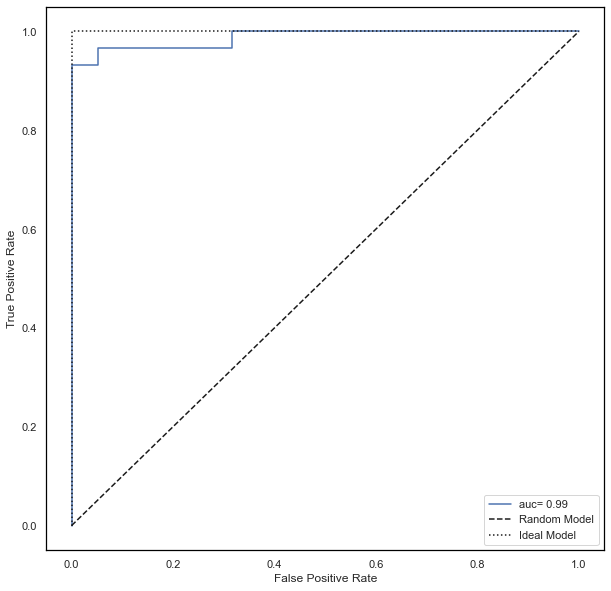

In [44]:
logistic_roc_curve(X,Y)

In [45]:
import clean_data

original_cancer_dataset = clean_data.generate_clean_dataframe()
original_cancer_dataset.reset_index(inplace=True)
cancer_Y = original_cancer_dataset["diagnosis"]
cancer_X = original_cancer_dataset.drop(["ID", "diagnosis"], axis=1)

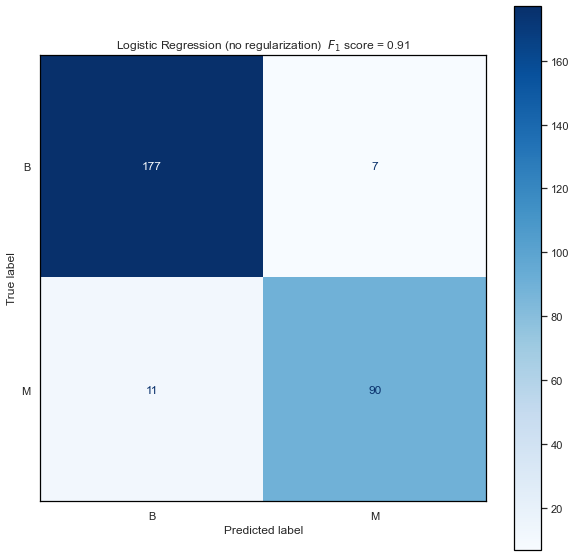

In [46]:
confusion_logisticRegressionClassifier(cancer_X,cancer_Y, plot=False)

In [51]:
@widgets.interact_manual(kernel=["linear", "poly", "rbf", "sigmoid"], C=(0,2))
def SVM_wrapper(kernel="linear", C=1):
    confusion_svmClassifier(kernel, C, cancer_X,cancer_Y, plot=False)

interactive(children=(Dropdown(description='kernel', options=('linear', 'poly', 'rbf', 'sigmoid'), value='line…

In [50]:
@widgets.interact_manual(K=(1, X.shape[0]))
def KNN_wrapper(K=5):
    confusion_nearestNeighborsClassifier(K, cancer_X,cancer_Y, plot=False)

interactive(children=(IntSlider(value=5, description='K', max=201, min=1), Button(description='Run Interact', …